# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                               std=[0.20, 0.20, 0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                               std=[0.20, 0.20, 0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = np.arange(data_size)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, dim=1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if scheduler is not None:
            scheduler.step()
        
        print("[%d/%d] Average loss: %f, Train accuracy: %f, Val accuracy: %f" % 
              (epoch + 1, num_epochs, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() 
    
    correct_samples = 0
    total_samples = 0
    for x, y in loader:
            prediction = model(x)
            indices = torch.argmax(prediction, dim=1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

[1/3] Average loss: 1.830642, Train accuracy: 0.406733, Val accuracy: 0.539485
[2/3] Average loss: 1.466428, Train accuracy: 0.576306, Val accuracy: 0.614634
[3/3] Average loss: 1.386685, Train accuracy: 0.616217, Val accuracy: 0.613132


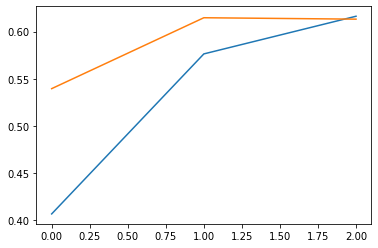

In [7]:
plt.plot(train_history)
plt.plot(val_history)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [8]:
# Since it's so easy to add layers, let's add some!
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

[1/5] Average loss: 2.181301, Train accuracy: 0.195185, Val accuracy: 0.212750
[2/5] Average loss: 2.010975, Train accuracy: 0.273794, Val accuracy: 0.331240
[3/5] Average loss: 1.797582, Train accuracy: 0.384312, Val accuracy: 0.419562
[4/5] Average loss: 1.704291, Train accuracy: 0.420947, Val accuracy: 0.433418
[5/5] Average loss: 1.678957, Train accuracy: 0.436372, Val accuracy: 0.445089


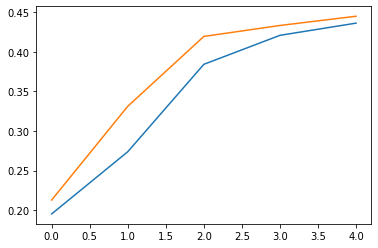

In [9]:
plt.plot(train_history)
plt.plot(val_history)

Добавьте слой с Batch Normalization

In [10]:
# We heard batch normalization is powerful, let's use it!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

[1/5] Average loss: 2.029846, Train accuracy: 0.322970, Val accuracy: 0.434987
[2/5] Average loss: 1.741356, Train accuracy: 0.475156, Val accuracy: 0.521807
[3/5] Average loss: 1.615159, Train accuracy: 0.539484, Val accuracy: 0.572725
[4/5] Average loss: 1.537288, Train accuracy: 0.581186, Val accuracy: 0.576343
[5/5] Average loss: 1.483503, Train accuracy: 0.608675, Val accuracy: 0.626647


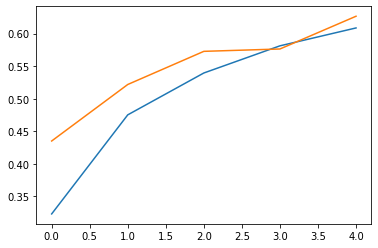

In [11]:
plt.plot(train_history)
plt.plot(val_history)

Добавьте уменьшение скорости обучения по ходу тренировки.

In [12]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, scheduler)

[1/5] Average loss: 2.072706, Train accuracy: 0.305668, Val accuracy: 0.422292
[2/5] Average loss: 1.778665, Train accuracy: 0.456353, Val accuracy: 0.501877
[3/5] Average loss: 1.654840, Train accuracy: 0.516227, Val accuracy: 0.538393
[4/5] Average loss: 1.596676, Train accuracy: 0.549261, Val accuracy: 0.568971
[5/5] Average loss: 1.556211, Train accuracy: 0.568713, Val accuracy: 0.584465


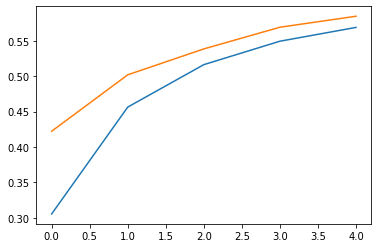

In [13]:
plt.plot(train_history)
plt.plot(val_history)

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [14]:
class SubsetSampler(Sampler):
    """
    Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    loader = torch.utils.data.DataLoader(dataset, sampler=SubsetSampler(indices))
    predictions = np.zeros(len(indices), dtype=int)
    ground_truth = np.zeros(len(indices), dtype=int)
    
    for i_step, (x, y) in enumerate(loader):
        pred = torch.argmax(model(x), dim=1)
        ground_truth[i_step] = y
        predictions[i_step] = pred
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

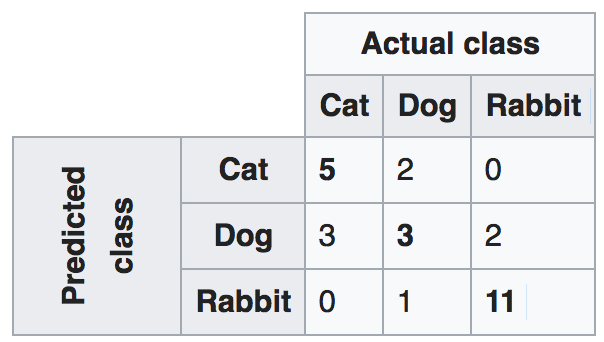

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

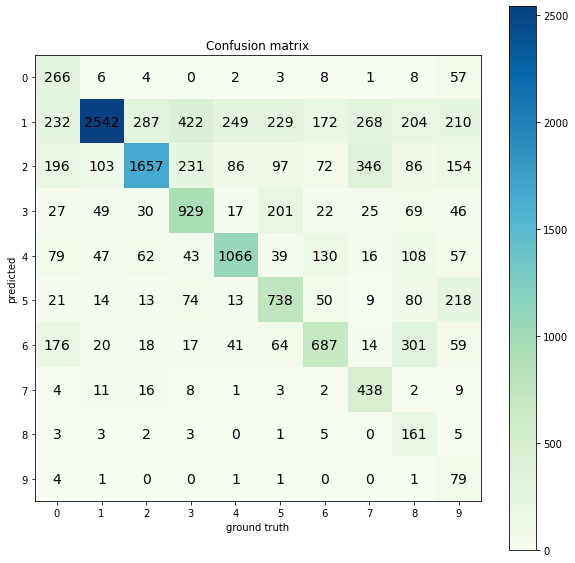

In [16]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10, 10), int)
    
    for pred in range(10):
        for gt in range(10):
            confusion_matrix[pred][gt] = np.sum((predictions == pred) & (ground_truth == gt))
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

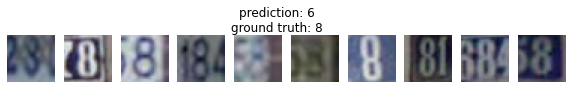

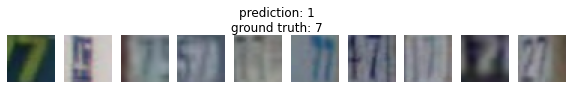

In [17]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    indices = val_indices[(predictions == predicted_class) & (ground_truth == gt_class)]
    title = 'prediction: ' + str(predicted_class) + '\nground truth: ' + str(gt_class)
    visualize_images(indices, data, title)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [18]:
import random

In [19]:
num_tries = 10

best_lr = None
best_acc = None

for try_num in range(num_tries):
    print('Try [%d/%d]' % (try_num + 1, num_tries))
    
    nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, 200),
                nn.BatchNorm1d(200),
                nn.ReLU(inplace=True),
                nn.Linear(200, 150),
                nn.BatchNorm1d(150),
                nn.ReLU(inplace=True),
                nn.Linear(150, 10)
             )
    
    lr = 10**random.uniform(-1, -6)
    print('Learning rate: ', lr)

    optimizer = optim.Adam(nn_model.parameters(), lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                           loss, optimizer, 10, scheduler)
    
    val_acc = val_history[-1]
    print('Validation accuracy: ', val_acc)
    
    if best_acc is None or val_acc > best_acc:
        best_acc = val_acc
        best_lr = lr
        print('*New best result*')
    print()
    
print('BEST RESULTS')
print('Learning rate: ', best_lr)
print('Validation accuracy: ', best_acc)

Try [1/10]
Learning rate:  0.024918555116182416
[1/10] Average loss: 1.510422, Train accuracy: 0.493209, Val accuracy: 0.588970
[2/10] Average loss: 1.237933, Train accuracy: 0.606610, Val accuracy: 0.623302
[3/10] Average loss: 1.174838, Train accuracy: 0.631215, Val accuracy: 0.642823
[4/10] Average loss: 1.144217, Train accuracy: 0.641197, Val accuracy: 0.626647
[5/10] Average loss: 1.122395, Train accuracy: 0.650206, Val accuracy: 0.627329
[6/10] Average loss: 1.097756, Train accuracy: 0.658687, Val accuracy: 0.671695
[7/10] Average loss: 1.079537, Train accuracy: 0.663209, Val accuracy: 0.616272
[8/10] Average loss: 1.065931, Train accuracy: 0.665836, Val accuracy: 0.599550
[9/10] Average loss: 1.052016, Train accuracy: 0.670938, Val accuracy: 0.678930
[10/10] Average loss: 1.034562, Train accuracy: 0.678736, Val accuracy: 0.685073
Validation accuracy:  0.6850726912838714
*New best result*

Try [2/10]
Learning rate:  0.001397172843265263
[1/10] Average loss: 1.311633, Train accura

[2/10] Average loss: 0.890972, Train accuracy: 0.720831, Val accuracy: 0.757491
[3/10] Average loss: 0.776393, Train accuracy: 0.757141, Val accuracy: 0.753123
[4/10] Average loss: 0.705429, Train accuracy: 0.779545, Val accuracy: 0.789775
[5/10] Average loss: 0.662915, Train accuracy: 0.791796, Val accuracy: 0.804655
[6/10] Average loss: 0.628628, Train accuracy: 0.802273, Val accuracy: 0.811890
[7/10] Average loss: 0.603210, Train accuracy: 0.812221, Val accuracy: 0.812846
[8/10] Average loss: 0.583742, Train accuracy: 0.817664, Val accuracy: 0.820285
[9/10] Average loss: 0.560607, Train accuracy: 0.825291, Val accuracy: 0.827384
[10/10] Average loss: 0.546492, Train accuracy: 0.828652, Val accuracy: 0.827247
Validation accuracy:  0.827247286874616

BEST RESULTS
Learning rate:  8.614670288645096e-05
Validation accuracy:  0.829909221213569


In [22]:
num_tries = 10

for try_num in range(num_tries):
    print('Try [%d/%d]' % (try_num + 1, num_tries))
    
    nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, 200),
                nn.BatchNorm1d(200),
                nn.ReLU(inplace=True),
                nn.Linear(200, 150),
                nn.BatchNorm1d(150),
                nn.ReLU(inplace=True),
                nn.Linear(150, 10)
             )
    
    lr = 10**random.uniform(-4, -5)
    print('Learning rate: ', lr)

    optimizer = optim.Adam(nn_model.parameters(), lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                           loss, optimizer, 10, scheduler)
    
    val_acc = val_history[-1]
    print('Validation accuracy: ', val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_lr = lr
        print('*New best result*')
    print()
    
print('BEST RESULTS')
print('Learning rate: ', best_lr)
print('Validation accuracy: ', best_acc)

Try [1/10]
Learning rate:  1.0339880865703282e-05
[1/10] Average loss: 2.014705, Train accuracy: 0.352592, Val accuracy: 0.537506
[2/10] Average loss: 1.584251, Train accuracy: 0.577774, Val accuracy: 0.625350
[3/10] Average loss: 1.381901, Train accuracy: 0.642938, Val accuracy: 0.671285
[4/10] Average loss: 1.254789, Train accuracy: 0.676108, Val accuracy: 0.700157
[5/10] Average loss: 1.161676, Train accuracy: 0.697710, Val accuracy: 0.713194
[6/10] Average loss: 1.086224, Train accuracy: 0.714756, Val accuracy: 0.725343
[7/10] Average loss: 1.030475, Train accuracy: 0.725455, Val accuracy: 0.738994
[8/10] Average loss: 0.980385, Train accuracy: 0.736614, Val accuracy: 0.746570
[9/10] Average loss: 0.938950, Train accuracy: 0.744582, Val accuracy: 0.753805
[10/10] Average loss: 0.904373, Train accuracy: 0.752227, Val accuracy: 0.759470
Validation accuracy:  0.7594703433212749
*New best result*

Try [2/10]
Learning rate:  6.26620400139977e-05
[1/10] Average loss: 1.529529, Train accu

[2/10] Average loss: 1.381024, Train accuracy: 0.640156, Val accuracy: 0.683093
[3/10] Average loss: 1.185035, Train accuracy: 0.689179, Val accuracy: 0.709917
[4/10] Average loss: 1.061657, Train accuracy: 0.716377, Val accuracy: 0.727322
[5/10] Average loss: 0.969936, Train accuracy: 0.735249, Val accuracy: 0.749096
[6/10] Average loss: 0.901781, Train accuracy: 0.748763, Val accuracy: 0.764316
[7/10] Average loss: 0.845902, Train accuracy: 0.763113, Val accuracy: 0.770528
[8/10] Average loss: 0.799456, Train accuracy: 0.774255, Val accuracy: 0.779879
[9/10] Average loss: 0.766600, Train accuracy: 0.781831, Val accuracy: 0.787114
[10/10] Average loss: 0.733795, Train accuracy: 0.790806, Val accuracy: 0.796328
Validation accuracy:  0.7963278957067776

BEST RESULTS
Learning rate:  6.760709552604411e-05
Validation accuracy:  0.8229472390963074


In [24]:
num_tries = 10

best_acc = None
best_wd = None

for try_num in range(num_tries):
    print('Try [%d/%d]' % (try_num + 1, num_tries))
    
    nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, 200),
                nn.BatchNorm1d(200),
                nn.ReLU(inplace=True),
                nn.Linear(200, 150),
                nn.BatchNorm1d(150),
                nn.ReLU(inplace=True),
                nn.Linear(150, 10)
             )
    
    wd = 10**random.uniform(-1, -7)
    print('Weight decay: ', wd)

    optimizer = optim.Adam(nn_model.parameters(), best_lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                           loss, optimizer, 10, scheduler)
    
    val_acc = val_history[-1]
    print('Validation accuracy: ', val_acc)
    
    if best_acc is None or val_acc > best_acc:
        best_acc = val_acc
        best_wd = wd
        print('*New best result*')
    print()
    
print('BEST RESULTS')
print('Weight decay: ', best_wd)
print('Validation accuracy: ', best_acc)

Try [1/10]
Weight decay:  4.02850474904928e-05
[1/10] Average loss: 1.534587, Train accuracy: 0.548033, Val accuracy: 0.695516
[2/10] Average loss: 1.025123, Train accuracy: 0.706566, Val accuracy: 0.723568
[3/10] Average loss: 0.863292, Train accuracy: 0.745555, Val accuracy: 0.766501
[4/10] Average loss: 0.764479, Train accuracy: 0.770314, Val accuracy: 0.782063
[5/10] Average loss: 0.698644, Train accuracy: 0.787906, Val accuracy: 0.795782
[6/10] Average loss: 0.649891, Train accuracy: 0.803007, Val accuracy: 0.803904
[7/10] Average loss: 0.615451, Train accuracy: 0.813244, Val accuracy: 0.816941
[8/10] Average loss: 0.585042, Train accuracy: 0.821452, Val accuracy: 0.819125
[9/10] Average loss: 0.559897, Train accuracy: 0.827936, Val accuracy: 0.823220
[10/10] Average loss: 0.538674, Train accuracy: 0.835887, Val accuracy: 0.813938
Validation accuracy:  0.8139376151798512
*New best result*

Try [2/10]
Weight decay:  1.4700931369669108e-06
[1/10] Average loss: 1.539118, Train accura

[2/10] Average loss: 1.070479, Train accuracy: 0.698563, Val accuracy: 0.731622
[3/10] Average loss: 0.898069, Train accuracy: 0.742296, Val accuracy: 0.754556
[4/10] Average loss: 0.801763, Train accuracy: 0.767652, Val accuracy: 0.778786
[5/10] Average loss: 0.735169, Train accuracy: 0.785210, Val accuracy: 0.796533
[6/10] Average loss: 0.690771, Train accuracy: 0.799509, Val accuracy: 0.790390
[7/10] Average loss: 0.659643, Train accuracy: 0.809439, Val accuracy: 0.817555
[8/10] Average loss: 0.632007, Train accuracy: 0.817510, Val accuracy: 0.814006
[9/10] Average loss: 0.612486, Train accuracy: 0.823141, Val accuracy: 0.817828
[10/10] Average loss: 0.596038, Train accuracy: 0.829403, Val accuracy: 0.826360
Validation accuracy:  0.8263599754282984

BEST RESULTS
Weight decay:  0.0002016313456792842
Validation accuracy:  0.830318749573408


Try [1/10]
Weight decay:  1.963208461274727e-05
[1/10] Average loss: 1.546592, Train accuracy: 0.539450, Val accuracy: 0.687939
[2/10] Average loss: 1.031615, Train accuracy: 0.705730, Val accuracy: 0.735991
[3/10] Average loss: 0.863141, Train accuracy: 0.744241, Val accuracy: 0.768548
[4/10] Average loss: 0.761589, Train accuracy: 0.770535, Val accuracy: 0.790731
[5/10] Average loss: 0.696337, Train accuracy: 0.788656, Val accuracy: 0.793393
[6/10] Average loss: 0.651311, Train accuracy: 0.801471, Val accuracy: 0.789571
[7/10] Average loss: 0.616213, Train accuracy: 0.810310, Val accuracy: 0.802061
[8/10] Average loss: 0.586075, Train accuracy: 0.821708, Val accuracy: 0.819125
[9/10] Average loss: 0.564115, Train accuracy: 0.827031, Val accuracy: 0.814620
[10/10] Average loss: 0.542273, Train accuracy: 0.834420, Val accuracy: 0.820695
Validation accuracy:  0.8206948331171934
*New best result*


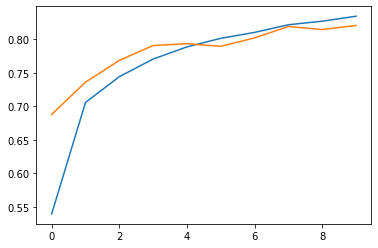

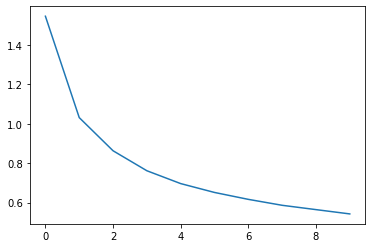


Try [2/10]
Weight decay:  1.5889631423665608e-05
[1/10] Average loss: 1.522272, Train accuracy: 0.549159, Val accuracy: 0.690055
[2/10] Average loss: 1.032849, Train accuracy: 0.703631, Val accuracy: 0.728073
[3/10] Average loss: 0.863472, Train accuracy: 0.742620, Val accuracy: 0.765545
[4/10] Average loss: 0.766955, Train accuracy: 0.769716, Val accuracy: 0.787387
[5/10] Average loss: 0.700832, Train accuracy: 0.788110, Val accuracy: 0.798649
[6/10] Average loss: 0.655665, Train accuracy: 0.800635, Val accuracy: 0.799945
[7/10] Average loss: 0.617085, Train accuracy: 0.812920, Val accuracy: 0.816054
[8/10] Average loss: 0.588090, Train accuracy: 0.820940, Val accuracy: 0.818784
[9/10] Average loss: 0.562350, Train accuracy: 0.828277, Val accuracy: 0.820627
[10/10] Average loss: 0.541511, Train accuracy: 0.834880, Val accuracy: 0.821241
Validation accuracy:  0.821240870930312
*New best result*


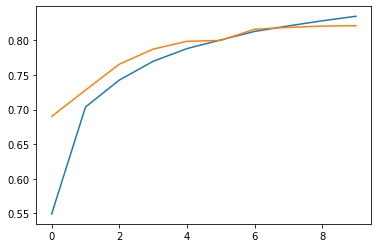

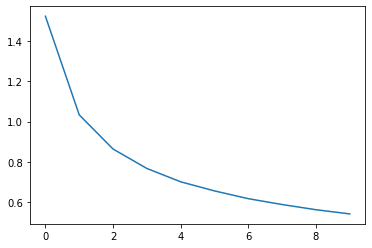


Try [3/10]
Weight decay:  0.00022000332523305343
[1/10] Average loss: 1.527442, Train accuracy: 0.553868, Val accuracy: 0.684322
[2/10] Average loss: 1.030662, Train accuracy: 0.706754, Val accuracy: 0.726708
[3/10] Average loss: 0.866425, Train accuracy: 0.745965, Val accuracy: 0.762951
[4/10] Average loss: 0.771969, Train accuracy: 0.768641, Val accuracy: 0.785475
[5/10] Average loss: 0.703527, Train accuracy: 0.786780, Val accuracy: 0.783155
[6/10] Average loss: 0.657820, Train accuracy: 0.798997, Val accuracy: 0.798103
[7/10] Average loss: 0.620753, Train accuracy: 0.811009, Val accuracy: 0.811617
[8/10] Average loss: 0.591347, Train accuracy: 0.820189, Val accuracy: 0.798171
[9/10] Average loss: 0.568012, Train accuracy: 0.827885, Val accuracy: 0.819125
[10/10] Average loss: 0.550504, Train accuracy: 0.831144, Val accuracy: 0.819535
Validation accuracy:  0.8195345027643164


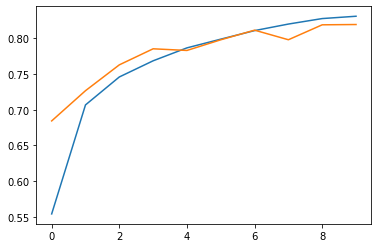

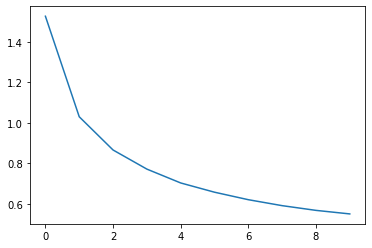


Try [4/10]
Weight decay:  0.00015439540837520286
[1/10] Average loss: 1.528239, Train accuracy: 0.550251, Val accuracy: 0.689441
[2/10] Average loss: 1.038005, Train accuracy: 0.700355, Val accuracy: 0.734216
[3/10] Average loss: 0.868208, Train accuracy: 0.742723, Val accuracy: 0.764726
[4/10] Average loss: 0.768744, Train accuracy: 0.768215, Val accuracy: 0.780425
[5/10] Average loss: 0.703886, Train accuracy: 0.787001, Val accuracy: 0.795577
[6/10] Average loss: 0.653505, Train accuracy: 0.801795, Val accuracy: 0.808409
[7/10] Average loss: 0.618767, Train accuracy: 0.812784, Val accuracy: 0.816190
[8/10] Average loss: 0.590107, Train accuracy: 0.820633, Val accuracy: 0.810320
[9/10] Average loss: 0.565504, Train accuracy: 0.827304, Val accuracy: 0.828681
[10/10] Average loss: 0.547935, Train accuracy: 0.832389, Val accuracy: 0.823562
Validation accuracy:  0.8235615316360658
*New best result*


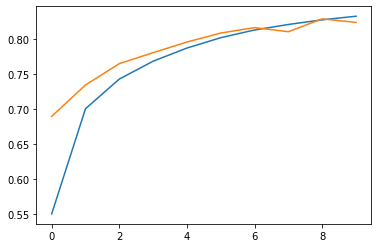

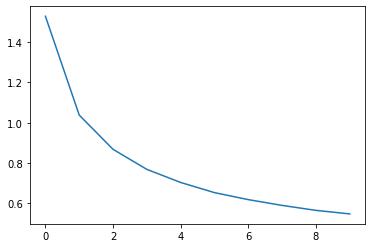


Try [5/10]
Weight decay:  2.1214405884499164e-05
[1/10] Average loss: 1.514693, Train accuracy: 0.555916, Val accuracy: 0.689714
[2/10] Average loss: 1.035542, Train accuracy: 0.702573, Val accuracy: 0.723568
[3/10] Average loss: 0.873655, Train accuracy: 0.740419, Val accuracy: 0.754010
[4/10] Average loss: 0.771548, Train accuracy: 0.768300, Val accuracy: 0.779674
[5/10] Average loss: 0.710416, Train accuracy: 0.786353, Val accuracy: 0.792096
[6/10] Average loss: 0.654420, Train accuracy: 0.803092, Val accuracy: 0.806430
[7/10] Average loss: 0.621443, Train accuracy: 0.813569, Val accuracy: 0.809501
[8/10] Average loss: 0.593701, Train accuracy: 0.818022, Val accuracy: 0.817146
[9/10] Average loss: 0.569608, Train accuracy: 0.826468, Val accuracy: 0.813323
[10/10] Average loss: 0.552596, Train accuracy: 0.831621, Val accuracy: 0.822196
Validation accuracy:  0.8221964371032694


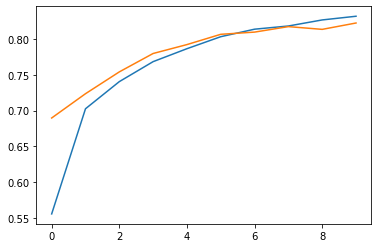

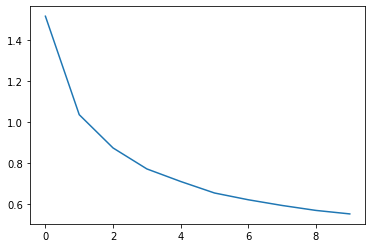


Try [6/10]
Weight decay:  9.601604347394094e-05
[1/10] Average loss: 1.515372, Train accuracy: 0.550166, Val accuracy: 0.669442
[2/10] Average loss: 1.033367, Train accuracy: 0.704075, Val accuracy: 0.711965
[3/10] Average loss: 0.866149, Train accuracy: 0.743815, Val accuracy: 0.764589
[4/10] Average loss: 0.762704, Train accuracy: 0.770518, Val accuracy: 0.779059
[5/10] Average loss: 0.699331, Train accuracy: 0.787923, Val accuracy: 0.791141
[6/10] Average loss: 0.649005, Train accuracy: 0.803706, Val accuracy: 0.803017
[7/10] Average loss: 0.616567, Train accuracy: 0.812750, Val accuracy: 0.813733
[8/10] Average loss: 0.584508, Train accuracy: 0.822510, Val accuracy: 0.815439
[9/10] Average loss: 0.562533, Train accuracy: 0.829164, Val accuracy: 0.825404
[10/10] Average loss: 0.537962, Train accuracy: 0.834437, Val accuracy: 0.824176
Validation accuracy:  0.8241758241758241
*New best result*


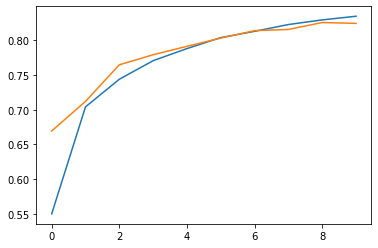

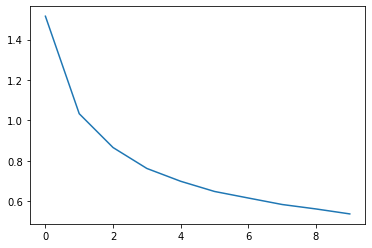


Try [7/10]
Weight decay:  0.0007563490976151557
[1/10] Average loss: 1.545654, Train accuracy: 0.543238, Val accuracy: 0.670193
[2/10] Average loss: 1.044641, Train accuracy: 0.698819, Val accuracy: 0.734216
[3/10] Average loss: 0.873061, Train accuracy: 0.741886, Val accuracy: 0.762405
[4/10] Average loss: 0.771259, Train accuracy: 0.769614, Val accuracy: 0.787864
[5/10] Average loss: 0.701259, Train accuracy: 0.790550, Val accuracy: 0.795577
[6/10] Average loss: 0.658326, Train accuracy: 0.800584, Val accuracy: 0.775510
[7/10] Average loss: 0.620471, Train accuracy: 0.812459, Val accuracy: 0.810252
[8/10] Average loss: 0.593601, Train accuracy: 0.819882, Val accuracy: 0.809569
[9/10] Average loss: 0.564259, Train accuracy: 0.828925, Val accuracy: 0.818715
[10/10] Average loss: 0.546096, Train accuracy: 0.832986, Val accuracy: 0.824995
Validation accuracy:  0.824994880895502
*New best result*


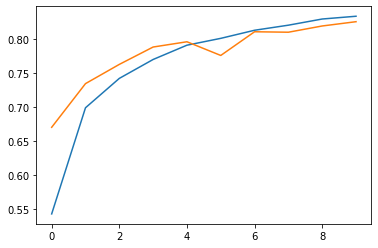

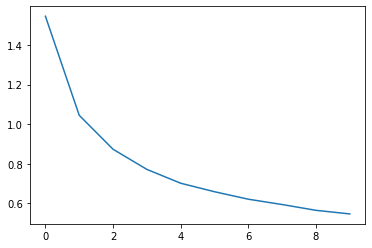


Try [8/10]
Weight decay:  0.000297169686452612
[1/10] Average loss: 1.513532, Train accuracy: 0.554841, Val accuracy: 0.691352
[2/10] Average loss: 1.027706, Train accuracy: 0.705764, Val accuracy: 0.729848
[3/10] Average loss: 0.858724, Train accuracy: 0.748473, Val accuracy: 0.764043
[4/10] Average loss: 0.756830, Train accuracy: 0.774341, Val accuracy: 0.782063
[5/10] Average loss: 0.691918, Train accuracy: 0.789817, Val accuracy: 0.803426
[6/10] Average loss: 0.648930, Train accuracy: 0.802529, Val accuracy: 0.810730
[7/10] Average loss: 0.613760, Train accuracy: 0.811419, Val accuracy: 0.814347
[8/10] Average loss: 0.583360, Train accuracy: 0.822203, Val accuracy: 0.824449
[9/10] Average loss: 0.559931, Train accuracy: 0.831297, Val accuracy: 0.820354
[10/10] Average loss: 0.542683, Train accuracy: 0.833703, Val accuracy: 0.831616
Validation accuracy:  0.8316155893795645
*New best result*


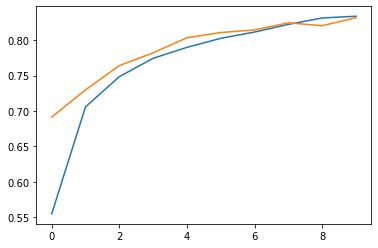

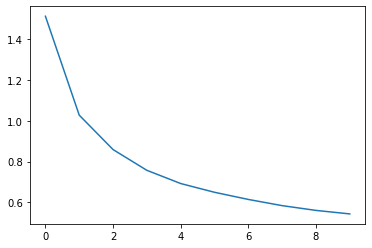


Try [9/10]
Weight decay:  5.887848002695567e-05
[1/10] Average loss: 1.528600, Train accuracy: 0.548016, Val accuracy: 0.688895
[2/10] Average loss: 1.036671, Train accuracy: 0.703375, Val accuracy: 0.748072
[3/10] Average loss: 0.869601, Train accuracy: 0.742398, Val accuracy: 0.747526
[4/10] Average loss: 0.768831, Train accuracy: 0.768761, Val accuracy: 0.781585
[5/10] Average loss: 0.700720, Train accuracy: 0.788486, Val accuracy: 0.801037
[6/10] Average loss: 0.652533, Train accuracy: 0.802478, Val accuracy: 0.800969
[7/10] Average loss: 0.615692, Train accuracy: 0.813756, Val accuracy: 0.812982
[8/10] Average loss: 0.580417, Train accuracy: 0.822612, Val accuracy: 0.821719
[9/10] Average loss: 0.557834, Train accuracy: 0.830205, Val accuracy: 0.818442
[10/10] Average loss: 0.540204, Train accuracy: 0.834607, Val accuracy: 0.827384
Validation accuracy:  0.8273837963278957


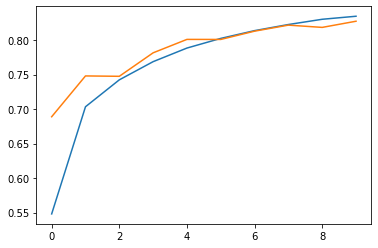

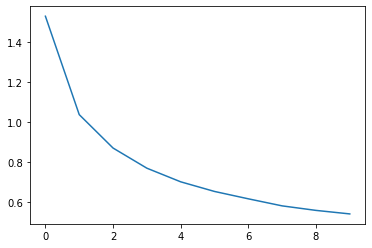


Try [10/10]
Weight decay:  8.334349966137731e-05
[1/10] Average loss: 1.526375, Train accuracy: 0.542743, Val accuracy: 0.674152
[2/10] Average loss: 1.030686, Train accuracy: 0.704501, Val accuracy: 0.748959
[3/10] Average loss: 0.856864, Train accuracy: 0.746579, Val accuracy: 0.769436
[4/10] Average loss: 0.761022, Train accuracy: 0.773368, Val accuracy: 0.784247
[5/10] Average loss: 0.692619, Train accuracy: 0.790568, Val accuracy: 0.798785
[6/10] Average loss: 0.644406, Train accuracy: 0.804337, Val accuracy: 0.787045
[7/10] Average loss: 0.611786, Train accuracy: 0.813859, Val accuracy: 0.804382
[8/10] Average loss: 0.582317, Train accuracy: 0.821401, Val accuracy: 0.817828
[9/10] Average loss: 0.557150, Train accuracy: 0.829779, Val accuracy: 0.826223
[10/10] Average loss: 0.535086, Train accuracy: 0.837184, Val accuracy: 0.823152
Validation accuracy:  0.8231520032762268


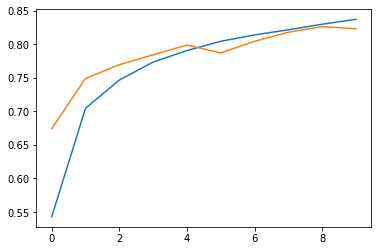

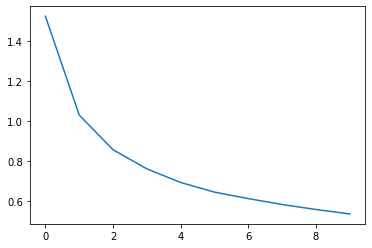


BEST RESULTS
Weight decay:  0.000297169686452612
Validation accuracy:  0.8316155893795645


In [26]:
num_tries = 10

for try_num in range(num_tries):
    print('Try [%d/%d]' % (try_num + 1, num_tries))
    
    nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, 200),
                nn.BatchNorm1d(200),
                nn.ReLU(inplace=True),
                nn.Linear(200, 150),
                nn.BatchNorm1d(150),
                nn.ReLU(inplace=True),
                nn.Linear(150, 10)
             )
    
    wd = 10**random.uniform(-3, -5)
    print('Weight decay: ', wd)

    optimizer = optim.Adam(nn_model.parameters(), best_lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                           loss, optimizer, 10, scheduler)
    
    val_acc = val_history[-1]
    print('Validation accuracy: ', val_acc)
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_wd = wd
        print('*New best result*')
    
    plt.plot(train_history)
    plt.plot(val_history)
    plt.show()
    plt.plot(loss_history)
    plt.show()
    
    print()
    
print('BEST RESULTS')
print('Weight decay: ', best_wd)
print('Validation accuracy: ', best_acc)

[1/50] Average loss: 1.530680, Train accuracy: 0.545627, Val accuracy: 0.683298
[2/50] Average loss: 1.037985, Train accuracy: 0.703256, Val accuracy: 0.741588
[3/50] Average loss: 0.864995, Train accuracy: 0.745026, Val accuracy: 0.765204
[4/50] Average loss: 0.765185, Train accuracy: 0.769495, Val accuracy: 0.784656
[5/50] Average loss: 0.699416, Train accuracy: 0.789356, Val accuracy: 0.800218
[6/50] Average loss: 0.650631, Train accuracy: 0.803143, Val accuracy: 0.780766
[7/50] Average loss: 0.615705, Train accuracy: 0.812732, Val accuracy: 0.799399
[8/50] Average loss: 0.585600, Train accuracy: 0.820633, Val accuracy: 0.819808
[9/50] Average loss: 0.559583, Train accuracy: 0.829215, Val accuracy: 0.822811
[10/50] Average loss: 0.542053, Train accuracy: 0.834488, Val accuracy: 0.830933
[11/50] Average loss: 0.521894, Train accuracy: 0.842798, Val accuracy: 0.832571
[12/50] Average loss: 0.508959, Train accuracy: 0.843958, Val accuracy: 0.839124
[13/50] Average loss: 0.492595, Train

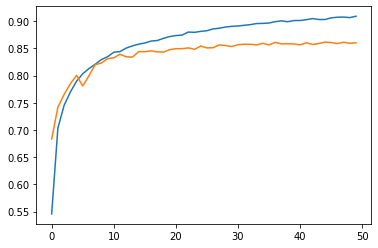

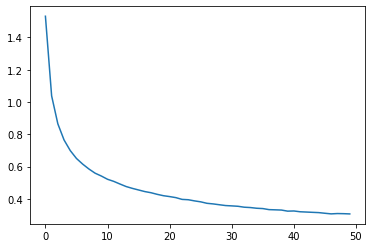

In [28]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(inplace=True),
            nn.Linear(150, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), best_lr, weight_decay=best_wd)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                       loss, optimizer, 50, scheduler)

val_acc = val_history[-1]
print('Validation accuracy: ', val_acc)

plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)
plt.show()

[1/50] Average loss: 2.105729, Train accuracy: 0.300328, Val accuracy: 0.461948
[2/50] Average loss: 1.739119, Train accuracy: 0.519179, Val accuracy: 0.573886
[3/50] Average loss: 1.541663, Train accuracy: 0.591578, Val accuracy: 0.624462
[4/50] Average loss: 1.405433, Train accuracy: 0.634867, Val accuracy: 0.657225
[5/50] Average loss: 1.301863, Train accuracy: 0.663140, Val accuracy: 0.680909
[6/50] Average loss: 1.217972, Train accuracy: 0.683855, Val accuracy: 0.695106
[7/50] Average loss: 1.145790, Train accuracy: 0.700321, Val accuracy: 0.712852
[8/50] Average loss: 1.087547, Train accuracy: 0.714074, Val accuracy: 0.722749
[9/50] Average loss: 1.034050, Train accuracy: 0.724056, Val accuracy: 0.737492
[10/50] Average loss: 0.990080, Train accuracy: 0.732229, Val accuracy: 0.744386
[11/50] Average loss: 0.949421, Train accuracy: 0.742415, Val accuracy: 0.748686
[12/50] Average loss: 0.912681, Train accuracy: 0.749445, Val accuracy: 0.755853
[13/50] Average loss: 0.882409, Train

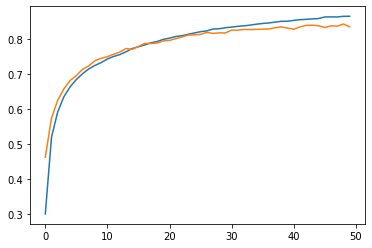

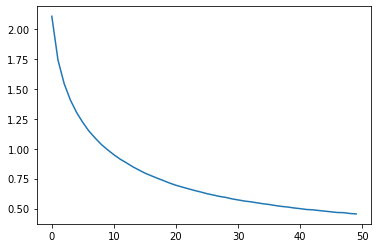

In [30]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(inplace=True),
            nn.Linear(150, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), best_lr, weight_decay=best_wd)
base_lr = best_lr / 10.0
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=best_lr, cycle_momentum=False)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                       loss, optimizer, 50, scheduler)

val_acc = val_history[-1]
print('Validation accuracy: ', val_acc)

plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)
plt.show()

In [31]:
def train_model_reduce_on_plateau(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            indices = torch.argmax(prediction, dim=1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        val_loss_accum = 0
        for i_step, (x, y) in enumerate(val_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            val_loss_accum += loss_value
        
        val_ave_loss = val_loss_accum / (i_step + 1)
        
        scheduler.step(val_ave_loss)
        
        print("[%d/%d] Average loss: %f, Train accuracy: %f, Val accuracy: %f" % 
              (epoch + 1, num_epochs, ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

[1/50] Average loss: 1.541166, Train accuracy: 0.543033, Val accuracy: 0.675995
[2/50] Average loss: 1.042176, Train accuracy: 0.701805, Val accuracy: 0.736332
[3/50] Average loss: 0.866397, Train accuracy: 0.743473, Val accuracy: 0.764385
[4/50] Average loss: 0.762918, Train accuracy: 0.772020, Val accuracy: 0.784315
[5/50] Average loss: 0.699245, Train accuracy: 0.788964, Val accuracy: 0.778513
[6/50] Average loss: 0.654168, Train accuracy: 0.800430, Val accuracy: 0.804587
[7/50] Average loss: 0.613911, Train accuracy: 0.812664, Val accuracy: 0.803904
[8/50] Average loss: 0.593336, Train accuracy: 0.816742, Val accuracy: 0.813733
[9/50] Average loss: 0.564226, Train accuracy: 0.827356, Val accuracy: 0.820831
[10/50] Average loss: 0.550796, Train accuracy: 0.828891, Val accuracy: 0.818442
[11/50] Average loss: 0.535001, Train accuracy: 0.834249, Val accuracy: 0.829841
[12/50] Average loss: 0.520009, Train accuracy: 0.838617, Val accuracy: 0.830524
[13/50] Average loss: 0.509123, Train

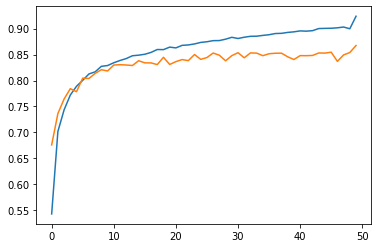

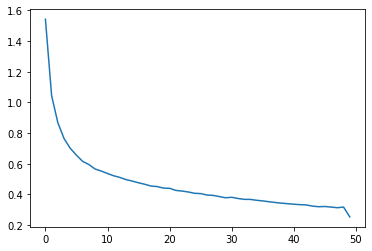

In [32]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(inplace=True),
            nn.Linear(150, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), best_lr, weight_decay=best_wd)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_history, train_history, val_history = train_model_reduce_on_plateau(nn_model, train_loader, val_loader, 
                                                                           loss, optimizer, 50, scheduler)

val_acc = val_history[-1]
print('Validation accuracy: ', val_acc)

plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)
plt.show()

[1/300] Average loss: 1.531680, Train accuracy: 0.549517, Val accuracy: 0.690465
[2/300] Average loss: 1.033638, Train accuracy: 0.705167, Val accuracy: 0.751280
[3/300] Average loss: 0.866258, Train accuracy: 0.745896, Val accuracy: 0.758924
[4/300] Average loss: 0.769073, Train accuracy: 0.768300, Val accuracy: 0.770732
[5/300] Average loss: 0.703786, Train accuracy: 0.785892, Val accuracy: 0.791209
[6/300] Average loss: 0.658893, Train accuracy: 0.799645, Val accuracy: 0.802266
[7/300] Average loss: 0.625902, Train accuracy: 0.809439, Val accuracy: 0.816668
[8/300] Average loss: 0.599125, Train accuracy: 0.815804, Val accuracy: 0.813187
[9/300] Average loss: 0.576581, Train accuracy: 0.823243, Val accuracy: 0.821241
[10/300] Average loss: 0.558103, Train accuracy: 0.828038, Val accuracy: 0.815303
[11/300] Average loss: 0.539069, Train accuracy: 0.834522, Val accuracy: 0.823562
[12/300] Average loss: 0.527074, Train accuracy: 0.836826, Val accuracy: 0.830387
[13/300] Average loss: 0.

[102/300] Average loss: 0.179999, Train accuracy: 0.948401, Val accuracy: 0.870384
[103/300] Average loss: 0.180568, Train accuracy: 0.947855, Val accuracy: 0.871340
[104/300] Average loss: 0.181861, Train accuracy: 0.947156, Val accuracy: 0.868132
[105/300] Average loss: 0.182225, Train accuracy: 0.946541, Val accuracy: 0.871749
[106/300] Average loss: 0.181678, Train accuracy: 0.947497, Val accuracy: 0.869906
[107/300] Average loss: 0.181226, Train accuracy: 0.948111, Val accuracy: 0.869497
[108/300] Average loss: 0.180346, Train accuracy: 0.948504, Val accuracy: 0.869497
[109/300] Average loss: 0.179136, Train accuracy: 0.948521, Val accuracy: 0.871545
[110/300] Average loss: 0.182990, Train accuracy: 0.945910, Val accuracy: 0.872091
[111/300] Average loss: 0.181207, Train accuracy: 0.947565, Val accuracy: 0.869906
[112/300] Average loss: 0.181499, Train accuracy: 0.947821, Val accuracy: 0.870316
[113/300] Average loss: 0.182177, Train accuracy: 0.947753, Val accuracy: 0.869838
[114

[201/300] Average loss: 0.181586, Train accuracy: 0.947770, Val accuracy: 0.871067
[202/300] Average loss: 0.180498, Train accuracy: 0.948862, Val accuracy: 0.868473
[203/300] Average loss: 0.181222, Train accuracy: 0.948981, Val accuracy: 0.869360
[204/300] Average loss: 0.181936, Train accuracy: 0.947121, Val accuracy: 0.869702
[205/300] Average loss: 0.182389, Train accuracy: 0.947002, Val accuracy: 0.869633
[206/300] Average loss: 0.181700, Train accuracy: 0.946046, Val accuracy: 0.869633
[207/300] Average loss: 0.180548, Train accuracy: 0.948128, Val accuracy: 0.869975
[208/300] Average loss: 0.182115, Train accuracy: 0.947667, Val accuracy: 0.869019
[209/300] Average loss: 0.181688, Train accuracy: 0.946883, Val accuracy: 0.870589
[210/300] Average loss: 0.179930, Train accuracy: 0.948128, Val accuracy: 0.869838
[211/300] Average loss: 0.181415, Train accuracy: 0.947889, Val accuracy: 0.870930
[212/300] Average loss: 0.180832, Train accuracy: 0.948248, Val accuracy: 0.869429
[213

[300/300] Average loss: 0.180917, Train accuracy: 0.947429, Val accuracy: 0.870862
Validation accuracy:  0.8708620571974609


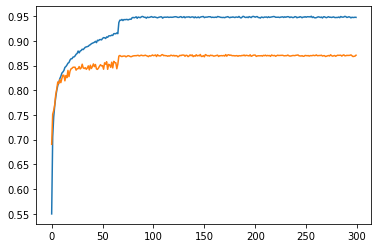

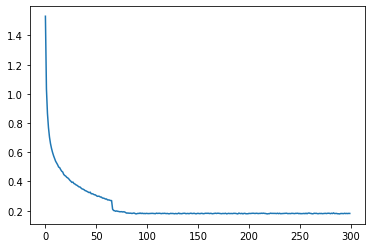

In [34]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 150),
            nn.BatchNorm1d(150),
            nn.ReLU(inplace=True),
            nn.Linear(150, 10)
         )

optimizer = optim.Adam(nn_model.parameters(), best_lr, weight_decay=best_wd)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
loss_history, train_history, val_history = train_model_reduce_on_plateau(nn_model, train_loader, val_loader, 
                                                                           loss, optimizer, 300, scheduler)

val_acc = val_history[-1]
print('Validation accuracy: ', val_acc)

plt.plot(train_history)
plt.plot(val_history)
plt.show()
plt.plot(loss_history)
plt.show()

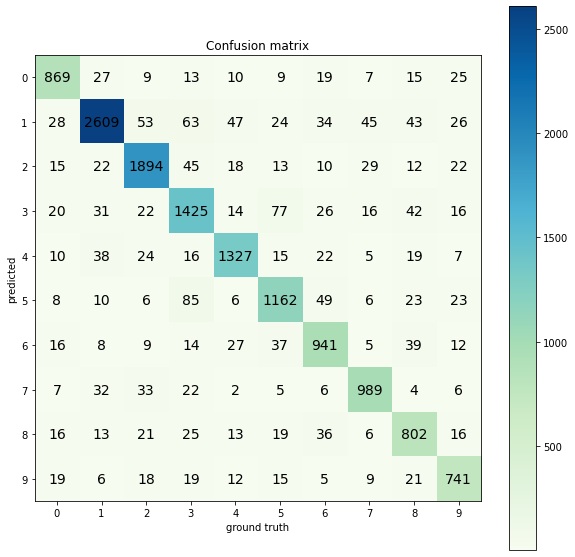

In [35]:
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

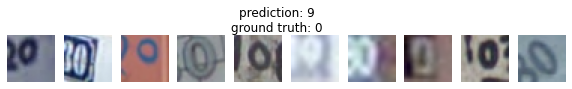

In [58]:
visualize_predicted_actual(9, 0, predictions, gt, np.array(val_indices), data_train_images)

In [59]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8517
